In [ ]:
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [56]:
def fitness_landscape(organism_column):
    fitness_value_for_organism = np.sum(organism_column)
    return fitness_value_for_organism

In [57]:
class world():
    def __init__(self, population_size, loci, gene_mean, gene_sd, proportion_asexual,
                 organism_capacity_percentage_of_initial_pop, asex_repl_ratio, sex_repl_ratio, mutation_prob):
        self.population_size = population_size
        self.loci = loci
        self.ones = np.ones(loci)
        self.organism_capacity = int(organism_capacity_percentage_of_initial_pop * population_size)
        self.asex_repl_ratio = asex_repl_ratio
        self.sex_repl_ratio = sex_repl_ratio
        self.total_pop_mat = (np.random.normal(gene_mean, gene_sd, (loci, self.population_size))).astype(int)
        self.separator = int(
        self.population_size * proportion_asexual)  # To indicate where the asex ends and sex begins
        self.mutation_prob = mutation_prob

    def population_sizes(self, total=False, asex=False, sex=False):
        if total == True:
            return self.total_pop_mat.shape[1]
        if asex == True:
            return self.asex_pop_mat.shape[1]
        if sex == True:
            return self.sex_pop_mat.shape[1]

    def mutation_stage(self, step=1):
        shape = self.total_pop_mat.shape
        half_liklihood = self.mutation_prob / 2
        mutation_matrix = np.random.choice([-step, 0, step], size=shape,
                                           p=[half_liklihood, 1 - self.mutation_prob, half_liklihood])
        self.total_pop_mat = self.total_pop_mat + mutation_matrix

    def calc_fitness_array(self, population = 0):
        if population == 0:
            population = self.total_pop_mat
        return np.apply_along_axis(fitness_landscape, 0, population)

    def species_fitness_statistics(self):
        self.fitness_array = self.calc_fitness_array()
        asex_fitness_array = self.fitness_array[:self.separator]
        asex_avg = np.average(asex_fitness_array)
        asex_std = np.std(asex_fitness_array)
        sex_fitness_array = self.fitness_array[self.separator:]
        sex_avg = np.average(sex_fitness_array)
        sex_std = np.std(sex_fitness_array)
        return asex_avg, asex_std, sex_avg, sex_std

    def survival_probability(self):
        # For now we make survival probability simply proportionate to
        # the fitness value. This is fine, and moves all the subtlety to the fitness landscape.
        self.fitness_array = self.calc_fitness_array()
        total_fitness = np.sum(self.fitness_array)
        prop_fitness = np.divide(self.fitness_array, total_fitness)
        return prop_fitness

    def survival_stage(self):
        curr_population_index = range(self.population_sizes(total=True))
        prop_fitness = self.survival_probability()
        # The following step may be a serious computational time issue
        survivor_list = np.random.choice(curr_population_index, self.organism_capacity, replace=False, p=prop_fitness)
        self.total_pop_mat = (self.total_pop_mat)[:, survivor_list]
        self.separator = np.size(np.where(survivor_list < self.separator))

        # For efficiencies sake, if we need it in replication stage, we should consider
        # updating the fitness array here, and so not calculating it in the replication stage
        # but currently replication isn't dependent on fitness
        # self.fitness_array = self.fitness_array[survivor_list]

    def asex_replication_stage(self):
        current_organism_index = np.arange(self.separator)
        next_gen_size = int(self.separator * self.asex_repl_ratio)
        next_gen_chosen = np.random.choice(current_organism_index, size=next_gen_size, replace=True)
        self.asex_pop_mat = self.asex_pop_mat[:, next_gen_chosen]

    def sexual_replication(self):
        total_sex_pop = self.population_sizes(sex=True)
        current_organism_index = np.arange(total_sex_pop)
        next_gen_size = int(total_sex_pop * self.sex_repl_ratio)

        def chosen_pairs():
            rounds = int(2 * next_gen_size / total_sex_pop) + 1
            mating_pairs = []
            for round in range(rounds):
                np.random.shuffle(current_organism_index)
                pairs = zip(current_organism_index[::2], current_organism_index[1::2])
                mating_pairs += pairs
            return mating_pairs[:next_gen_size]

        chosen_pairs = chosen_pairs()  # list of 2-tuples to be replicated

        def mate_pairs():
            next_gen = []
            for pair in chosen_pairs:
                parent_1, parent_2 = pair
                parent_1_gene_index = np.random.randint(2, size=(self.loci))
                parent_1_genes = np.reshape(np.multiply(self.sex_pop_mat[:, parent_1], parent_1_gene_index), self.loci)
                parent_2_gene_index = self.ones - parent_1_gene_index
                parent_2_genes = np.reshape(np.multiply(self.sex_pop_mat[:, parent_2], parent_2_gene_index), self.loci)
                child = np.add(parent_1_genes, parent_2_genes)
                next_gen.append(child)
            return np.transpose(np.asarray(next_gen))

        # CHECK THE TRANSPOSE STATEMENT IN THE LINE ABOVE
        self.sex_pop_mat = mate_pairs()

    def pop_size_preserving_repl_rates(self):
        current_pop_size = self.population_sizes(total=True)
        ratio = self.population_size / current_pop_size
        self.sex_repl_ratio, self.asex_repl_ratio = ratio, ratio

    def replication_stage(self, pop_size_preserving=False):
        def gen_sex_asex_matrices(self):
            return self.total_pop_mat[:, :self.separator], self.total_pop_mat[:, self.separator:]
        self.asex_pop_mat, self.sex_pop_mat = gen_sex_asex_matrices(self)
        if pop_size_preserving == True:
            self.pop_size_preserving_repl_rates()
        self.asex_replication_stage()
        self.sexual_replication()
        # REGENERATE THE TOTAL POP MATRIX:
        self.total_pop_mat = np.concatenate([self.asex_pop_mat, self.sex_pop_mat], axis=1)
        self.separator = self.asex_pop_mat.shape[1]

    def iteration(self, post_text=False, pre_text=False, avg_fitness =False):
        if pre_text == True:
            print('Pre Sexual size: ', self.population_sizes(sex=True))
            print('Pre Asexual Pop Size: ', self.population_sizes(asex=True))
        self.mutation_stage()
        self.survival_stage()
        if avg_fitness==True:
            asex_avg, asex_std, sex_avg, sex_std = self.species_fitness_statistics()
            print('ASEX AVG FITNESS: ', asex_avg,' std', asex_std)
            print('SEX AVG FITNESS:', sex_avg, 'std', sex_std)
        self.replication_stage(pop_size_preserving=True)
        if post_text == True:
            print('----------------------------------')
            print('Post Sexual size: ', self.population_sizes(sex=True))
            print('Post Asexual Pop Size: ', self.population_sizes(asex=True))
            print('Post Total Pop Size: ', self.population_sizes(total=True))

    def top_10_perc_asex(self):
        fitness_array = self.calc_fitness_array()
        pop_size = len(fitness_array)
        num_10_perc = int(len(fitness_array)*0.1)
        top_positions = np.argsort(fitness_array)[-num_10_perc:]
        print(np.shape(np.where(top_positions < self.separator)))
        num_asex = np.shape(np.where(top_positions < self.separator))[1]
        percent_top_asex = num_asex/num_10_perc
        perc_population = self.separator/pop_size
        return percent_top_asex, perc_population

    def plot_loci_3d(self, fitness = False, proportions = False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        if fitness == True:
            fitness_array = self.calc_fitness_array()
            fitness_array.shape = (1, len(fitness_array))
            total_pop_2d = self.total_pop_mat[:2,:]
            plot_3d = np.concatenate((total_pop_2d, fitness_array), 0)
        elif proportions==True:
            prop_fitness = self.survival_probability()
            prop_fitness.shape = (1, len(prop_fitness))
            total_pop_2d = self.total_pop_mat[:2,:]
            plot_3d = np.concatenate((total_pop_2d, prop_fitness), 0)            
        else:
            #total_pop_3d:
            plot_3d = self.total_pop_mat[:3,:]
        asex_3d = plot_3d[:,:self.separator]
        sex_3d = plot_3d[:,self.separator:]
        for m,species in [('o', asex_3d),('v', sex_3d)]:  #('o', asex_3d),
            xs = species[0, :]
            ys = species[1, :]
            zs = species[2, :]
            ax.scatter(xs, ys, zs, marker=m)
        ax.set_xlabel('Loci 0')
        ax.set_ylabel('Loci 1')
        if fitness == True:
            ax.set_zlabel('Fitness')
        else:
            ax.set_zlabel('Loci 2')
        
        plt.show()



world iteration:  0
(1, 239)
Percent of top 10% thats asexual, Perc of total pop asexual (0.4789579158316633, 0.501500300060012)
(1, 275)
Percent of top 10% thats asexual, Perc of total pop asexual (0.55, 0.552)
(1, 320)
Percent of top 10% thats asexual, Perc of total pop asexual (0.6412825651302605, 0.6173234646929386)
(1, 300)
Percent of top 10% thats asexual, Perc of total pop asexual (0.6012024048096193, 0.5917183436687338)
(1, 293)
Percent of top 10% thats asexual, Perc of total pop asexual (0.5871743486973948, 0.5535107021404281)
(1, 275)
Percent of top 10% thats asexual, Perc of total pop asexual (0.5511022044088176, 0.5695139027805561)
(1, 284)
Percent of top 10% thats asexual, Perc of total pop asexual (0.5691382765531062, 0.5717143428685737)
(1, 276)
Percent of top 10% thats asexual, Perc of total pop asexual (0.552, 0.591)
(1, 325)
Percent of top 10% thats asexual, Perc of total pop asexual (0.65, 0.606)
(1, 287)
Percent of top 10% thats asexual, Perc of total pop asexual (0

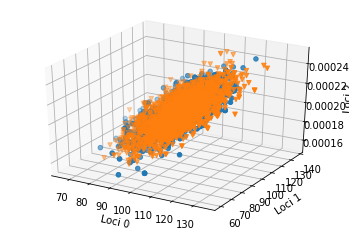

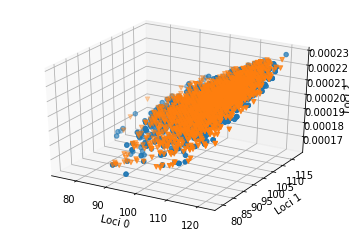

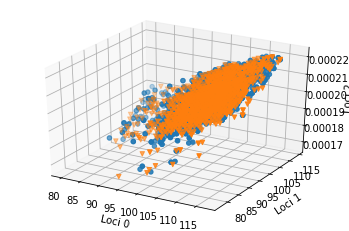

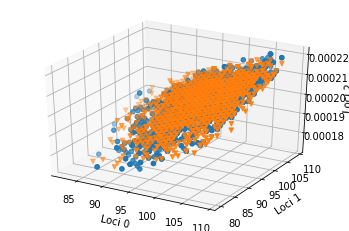

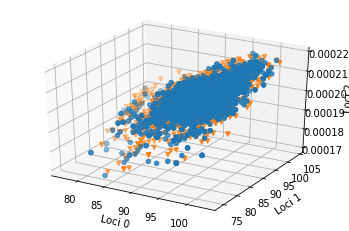

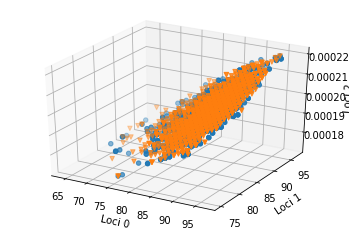

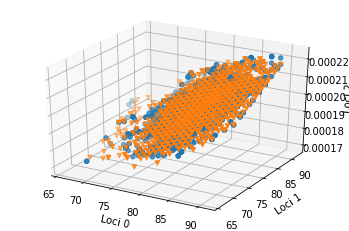

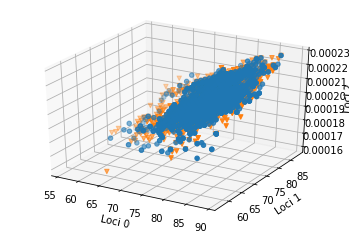

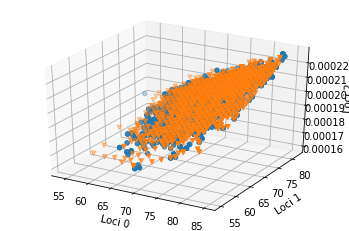

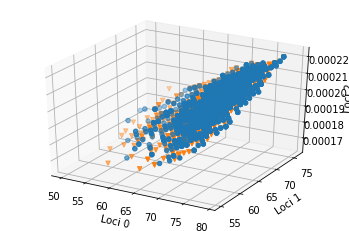

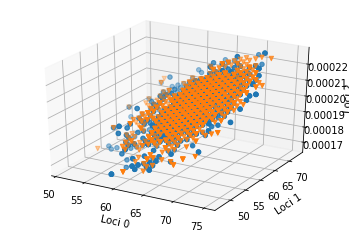

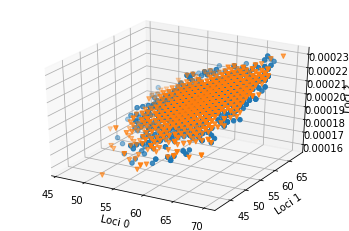

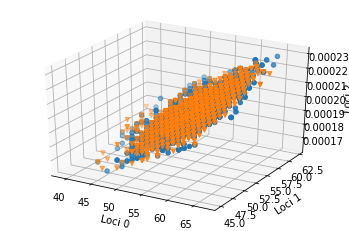

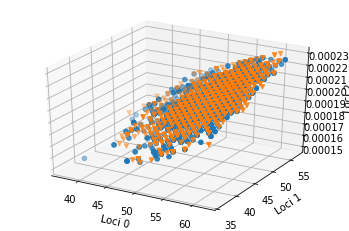

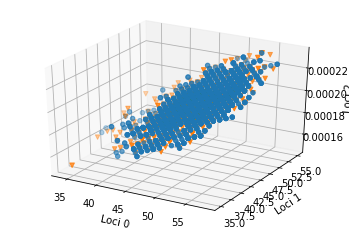

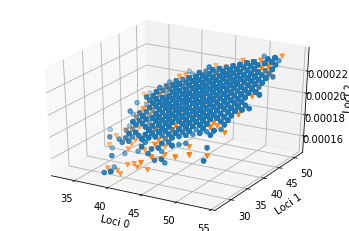

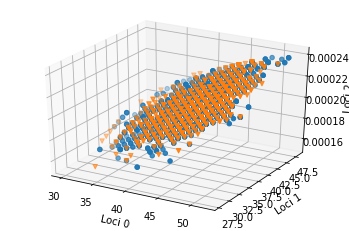

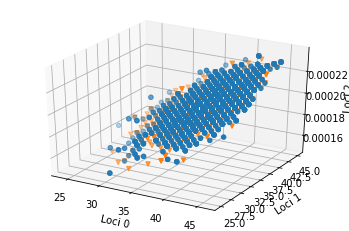

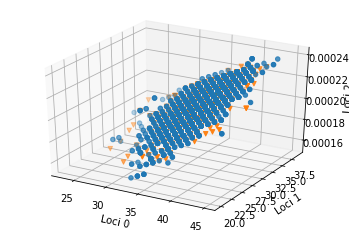

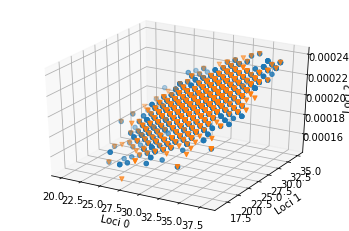

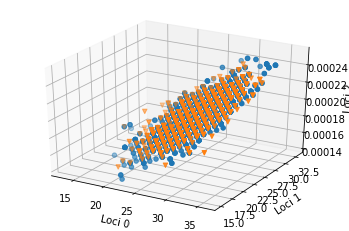

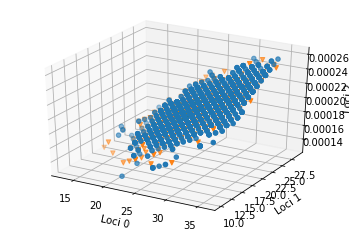

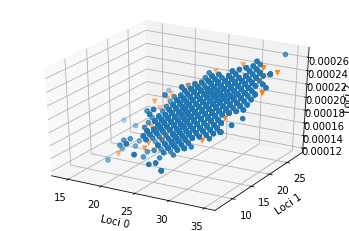

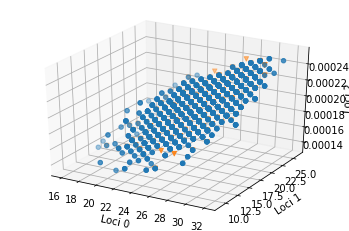

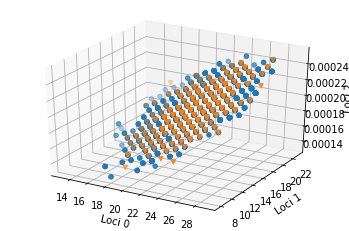

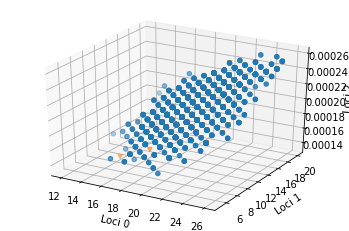

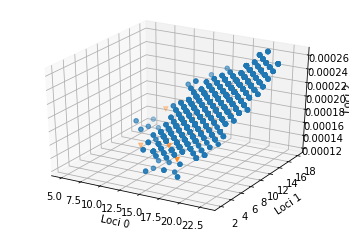

In [59]:
lengths = []
list_statistics = []
sexual_success = 0
asexual_success = 0
with open("results.txt", "w") as myfile:
    myfile.write('Thread one has begun \n')
for i in range(1):
    statistics_per_world = []
    print('world iteration: ',i)
    population_size = 5000
    gia = world(population_size, 2, 100, 10, 0.5, 0.8, 10/8, 10/8, 0.1)
    for x in range(10000):
        if x%100 == 0:
            gia.iteration()
            gia.plot_loci_3d(proportions=True)
            print('Percent of top 10% thats asexual, Perc of total pop asexual', gia.top_10_perc_asex())
        else:
            gia.iteration()
        statistics_per_world.append(gia.species_fitness_statistics())
        if gia.separator>population_size-100:
            asexual_success += 1
            break
        if gia.separator<100:
            sexual_success+=1
            break
    list_statistics.append(statistics_per_world)
    print('SEX:', sexual_success, 'ASEX:', asexual_success)
    with open("results.txt", "a") as myfile:
        myfile.write('SEX:'+ str(sexual_success)+ 'ASEX:'+ str(asexual_success)+'\n')
    lengths.append(x)


out1 = 'Sex:' + str(sexual_success) +' Asex:'+ str(asexual_success)
out2 = 'AVG: '+ str(np.average(lengths))+' STD:'+ str(np.std(lengths))

# Saving the objects:
with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([out1, out2, list_statistics], f)

#with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#    obj0, obj1, obj2 = pickle.load(f)

In [33]:
print('hello')

hello
